In [5]:
from pathlib import Path
from types import SimpleNamespace
from tqdm.auto import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import albumentations as A
import wandb
from albumentations.pytorch.transforms import ToTensorV2
from accelerate import Accelerator
from datasets import load_dataset
from diffusers import AutoencoderKL

In [6]:
model = AutoencoderKL(
        in_channels=3,
        down_block_types=("DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D"),
        up_block_types=("UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D"),
        block_out_channels=(32, 64, 128),
        layers_per_block=2,
    )
acclerator = Accelerator()
model = acclerator.prepare(model)
acclerator.load_state("outputs/10")
dataset = load_dataset('mnist', split='test')

Found cached dataset mnist (/home/kyle/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


In [7]:
transform_train = A.Compose([
    A.Resize(32, 32),
    # A.HorizontalFlip(),
    A.ToFloat(255),
    ToTensorV2()
])
def transforms(examples):
    examples["image"] = [transform_train(image=np.array(image.convert("RGB")))['image'] for image in examples["image"]]
    return examples
dataset.set_transform(transforms)
example = {}
ii, jj = 4, 7
for data in dataset:
    if data['label'] in [ii, jj]:
        example[data['label']] = data['image']
print(example[ii].shape)

model.to(0)
model.eval()
example[ii] = model.encode(example[ii].to(0).unsqueeze(0)).latent_dist.sample()
example[jj] = model.encode(example[jj].to(0).unsqueeze(0)).latent_dist.sample()
print(example[ii].shape)

torch.Size([3, 32, 32])
torch.Size([1, 4, 8, 8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


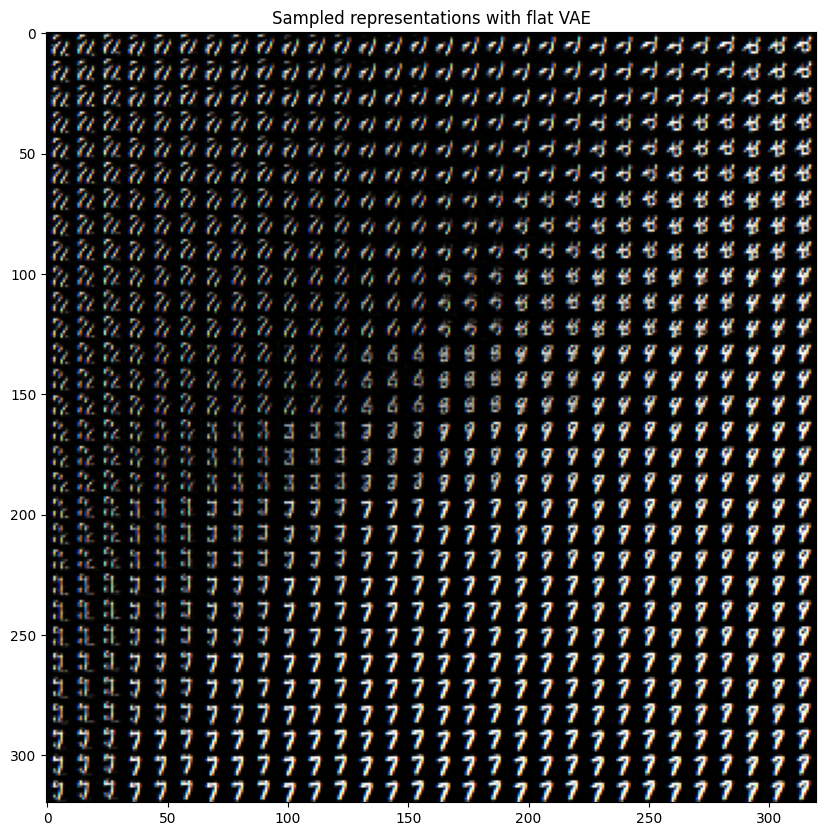

In [8]:

# display a 2D manifold of the digits
n = 10 # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n, 3))

from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = xi * example[ii] + yi * example[jj]
        x_decoded = model.decode(z_sample).sample
        x_decoded = x_decoded.detach().cpu().numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size, 3)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title('Sampled representations with flat VAE')
plt.imshow(figure, cmap='Greys_r')
plt.savefig('outputs/repr_VAE_flat.png')
plt.show()